# libraries and initializing spark session

In [1]:
#loading the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dask.dataframe as dd

import seaborn as sns

#from google.colab import files
#uploaded = files.upload()
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# import findspark
# findspark.init()
# import pyspark
# from pyspark.sql import SparkSession
# spark = SparkSession.builder.appName('sertis')\
# .config('spark-master', 'local')\
# .getOrCreate()
# from pyspark.sql.functions import col, lit


# Install Java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# Install PySpark
!pip install pyspark

# Initialize Spark Session
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("sertis") \
    .getOrCreate()

In [20]:
from pyspark.sql.functions import col, lit
from pyspark import SparkContext, SparkConf
from pyspark.ml import Pipeline
from pyspark.ml.linalg import DenseMatrix, Vectors
from pyspark.ml.stat import Correlation
from pyspark.mllib.stat import Statistics
from typing import List, Tuple, Dict
from pyspark.sql import Row, DataFrame
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, DecisionTreeClassifier
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler
from pyspark.ml.evaluation import BinaryClassificationEvaluator, RegressionEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.regression import RandomForestRegressor
from sklearn.metrics import confusion_matrix
from pyspark.sql.functions import when, col
from pyspark.sql.functions import mean
from pyspark.sql.functions import col, round
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import DecisionTreeRegressor

# preprocessing

In [4]:
#loading the training dataset

file_path = '/content/drive/My Drive/train.csv'
df = spark.read.csv(file_path, header=True, inferSchema=True)
df.printSchema()
df.show(5)


#unused codes:
# df = dd.read_csv(file_path)
#df = ddf.compute()
# print(df.head())
# row_count = len(df)
# print("Total rows:", row_count)

root
 |-- id: integer (nullable = true)
 |-- date: date (nullable = true)
 |-- store_nbr: integer (nullable = true)
 |-- item_nbr: integer (nullable = true)
 |-- unit_sales: double (nullable = true)
 |-- onpromotion: boolean (nullable = true)

+---+----------+---------+--------+----------+-----------+
| id|      date|store_nbr|item_nbr|unit_sales|onpromotion|
+---+----------+---------+--------+----------+-----------+
|  0|2013-01-01|       25|  103665|       7.0|       NULL|
|  1|2013-01-01|       25|  105574|       1.0|       NULL|
|  2|2013-01-01|       25|  105575|       2.0|       NULL|
|  3|2013-01-01|       25|  108079|       1.0|       NULL|
|  4|2013-01-01|       25|  108701|       1.0|       NULL|
+---+----------+---------+--------+----------+-----------+
only showing top 5 rows



In [5]:
#for first round of data cleaning, i will remove the id column as it does not affectr the target variable at all and is simply an identifier
#i will be removing all rows with negative values in unit_sales due to returning of products
#i will all fill the empty cells in the onpromotion tab
df1 = df.drop('id')
df1 = df1.filter(df['unit_sales'] >= 0)
df1.show(5)


#unused codes:
# df = pd.read_csv(file_path)
# df.drop(columns=['id'], inplace=True)
# df.drop(df.loc[df['unit_sales'] < 0].index, inplace=True)
# df['onpromotion'].fillna('no', inplace=True)

+----------+---------+--------+----------+-----------+
|      date|store_nbr|item_nbr|unit_sales|onpromotion|
+----------+---------+--------+----------+-----------+
|2013-01-01|       25|  103665|       7.0|       NULL|
|2013-01-01|       25|  105574|       1.0|       NULL|
|2013-01-01|       25|  105575|       2.0|       NULL|
|2013-01-01|       25|  108079|       1.0|       NULL|
|2013-01-01|       25|  108701|       1.0|       NULL|
+----------+---------+--------+----------+-----------+
only showing top 5 rows



from the start, i have been using pandas and kept expereincing lack of ram.
after digging around, i finally realised that this problem requires parallel computing and hence requires me to use libraires like dask or spark. i will be using spark to tackle this problem due to it being more familiar to me.

In [27]:
#loading the other datasets
file_path_2 = '/content/drive/My Drive/holidays_events.csv'
df_he = spark.read.csv(file_path_2, header=True, inferSchema=True)
df_he.printSchema()
df_he.show(5)

file_path_3 = '/content/drive/My Drive/oil.csv'
df_o = spark.read.csv(file_path_3, header=True, inferSchema=True)
df_o.printSchema()
df_o.show(5)

file_path_4 = '/content/drive/My Drive/items.csv'
df_i = spark.read.csv(file_path_4, header=True, inferSchema=True)
df_i.printSchema()
df_i.show(5)

file_path_5 = '/content/drive/My Drive/stores.csv'
df_s = spark.read.csv(file_path_5, header=True, inferSchema=True)
df_s.printSchema()
df_s.show(5)

file_path_6 = '/content/drive/My Drive/transactions.csv'
df_t = spark.read.csv(file_path_6, header=True, inferSchema=True)
df_t.printSchema()
df_t.show(5)


# # unused code:
# file_path_2 = '/content/drive/My Drive/holidays_events.csv'
# df_he = pd.read_csv(file_path_2)
# print(df_he.head())
# #row_count = len(df_he)
# #print("Total rows:", row_count)

# file_path_3 = '/content/drive/My Drive/oil.csv'
# df_o = pd.read_csv(file_path_3)
# print(df_o.head())
# #row_count = len(df_o)
# #print("Total rows:", row_count)

# file_path_4 = '/content/drive/My Drive/items.csv'
# df_i = pd.read_csv(file_path_4)
# print(df_i.head())
# #row_count = len(df_i)
# #print("Total rows:", row_count)

# file_path_5 = '/content/drive/My Drive/stores.csv'
# df_s = pd.read_csv(file_path_5)
# print(df_s.head())
# #row_count = len(df_s)
# #print("Total rows:", row_count)

# file_path_6 = '/content/drive/My Drive/transactions.csv'
# df_t = pd.read_csv(file_path_6)
# print(df_t.head())
# #row_count = len(df_t)
# #print("Total rows:", row_count)

root
 |-- date: date (nullable = true)
 |-- type: string (nullable = true)
 |-- locale: string (nullable = true)
 |-- locale_name: string (nullable = true)
 |-- description: string (nullable = true)
 |-- transferred: boolean (nullable = true)

+----------+-------+--------+-----------+--------------------+-----------+
|      date|   type|  locale|locale_name|         description|transferred|
+----------+-------+--------+-----------+--------------------+-----------+
|2012-03-02|Holiday|   Local|      Manta|  Fundacion de Manta|      false|
|2012-04-01|Holiday|Regional|   Cotopaxi|Provincializacion...|      false|
|2012-04-12|Holiday|   Local|     Cuenca| Fundacion de Cuenca|      false|
|2012-04-14|Holiday|   Local|   Libertad|Cantonizacion de ...|      false|
|2012-04-21|Holiday|   Local|   Riobamba|Cantonizacion de ...|      false|
+----------+-------+--------+-----------+--------------------+-----------+
only showing top 5 rows

root
 |-- date: date (nullable = true)
 |-- dcoilwtico: 

Exploring the datasets

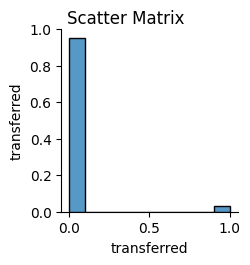

In [29]:
#converting to pandas dataset
pd_he = df_he.toPandas()
#visualising the data
sns.pairplot(pd_he)
plt.suptitle('days transfered', y=1.02)
plt.show()

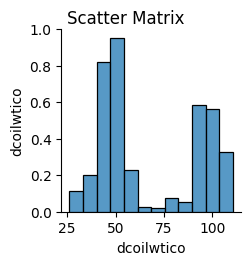

In [30]:
#converting to pandas dataset
pd_o = df_o.toPandas()
#visualising the data
sns.pairplot(pd_o)
plt.suptitle('daily oil prices', y=1.02)
plt.show()

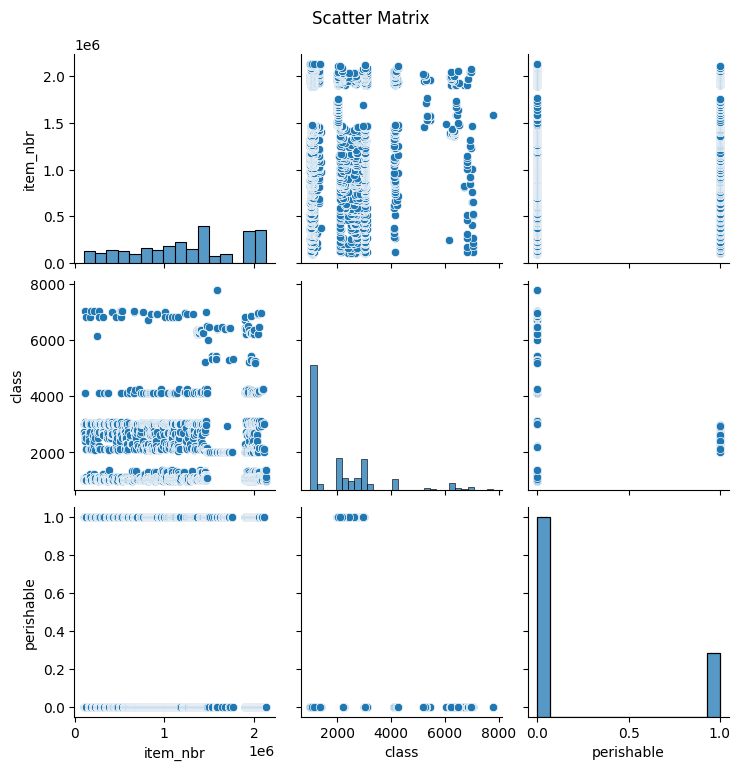

In [31]:
#converting to pandas dataset
pd_i = df_i.toPandas()
#visualising the data
sns.pairplot(pd_i)
plt.suptitle('Scatter Matrix', y=1.02)
plt.show()

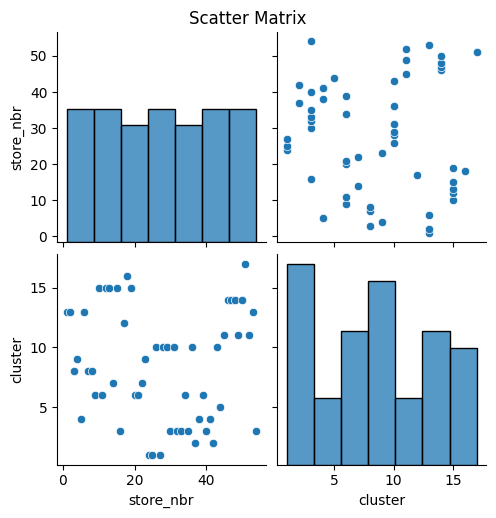

In [32]:
#converting to pandas dataset
pd_s = df_s.toPandas()
#visualising the data
sns.pairplot(pd_s)
plt.suptitle('Scatter Matrix', y=1.02)
plt.show()

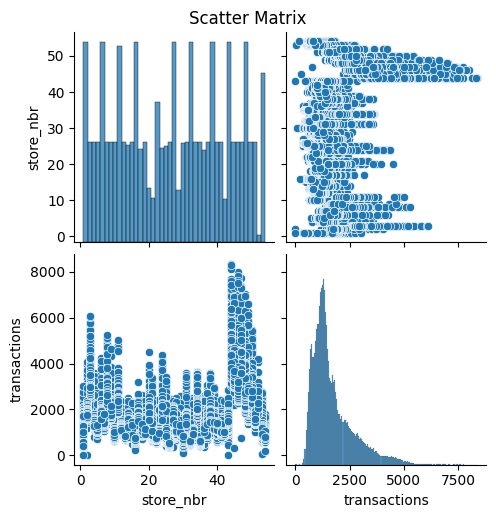

In [33]:
#converting to pandas dataset
pd_t = df_t.toPandas()
#visualising the data
sns.pairplot(pd_t)
plt.suptitle('Scatter Matrix', y=1.02)
plt.show()

In [7]:
#adjusting the holiday events df
#create a new col called hol_true, by removing the transfered and type columns.
#if the transfered value is true, hol_true will return 0
#if the type is transfer or additional, hol_true will return 1
df_he = df_he.withColumn('hol_true',
                        when(df_he['type'] == 'Transfer', 1)
                        .when(df_he['transferred'] == 'TRUE', 0)
                        .otherwise(1))
df_he = df_he.drop('transferred', 'type')
df_he.show(5)


# unused code
# def create_new_column(row):
#     if row['type'] == "Transfer":
#       return 1
#     elif row['transferred'] == 'TRUE':
#       return 0
#     else:
#       return 1

# df_he['hol_true'] = df_he.apply(create_new_column, axis=1)
# df_he.drop(columns=['transferred'], inplace=True)
# df_he.drop(columns=['type'], inplace=True)
# print(df_he.head())

+----------+--------+-----------+--------------------+--------+
|      date|  locale|locale_name|         description|hol_true|
+----------+--------+-----------+--------------------+--------+
|2012-03-02|   Local|      Manta|  Fundacion de Manta|       1|
|2012-04-01|Regional|   Cotopaxi|Provincializacion...|       1|
|2012-04-12|   Local|     Cuenca| Fundacion de Cuenca|       1|
|2012-04-14|   Local|   Libertad|Cantonizacion de ...|       1|
|2012-04-21|   Local|   Riobamba|Cantonizacion de ...|       1|
+----------+--------+-----------+--------------------+--------+
only showing top 5 rows



In [8]:
#cleaning the oil dataframe
mean_value = df_o.select(mean('dcoilwtico')).collect()[0][0]
print(mean_value)
df_o = df_o.na.fill({'dcoilwtico': mean_value})
df_o.show(5)


#unused code
# df_o['dcoilwtico'].fillna(df_o['dcoilwtico'].mean(), inplace=True)
# print(df_o.head())

67.71436595744689
+----------+-----------------+
|      date|       dcoilwtico|
+----------+-----------------+
|2013-01-01|67.71436595744689|
|2013-01-02|            93.14|
|2013-01-03|            92.97|
|2013-01-04|            93.12|
|2013-01-07|             93.2|
+----------+-----------------+
only showing top 5 rows



In [9]:
#making sure that a specific store is affected by a holiday
#national is celebrated by all
#region is celebrated by locals in the state
#local oonly celebrated within the city
# part 1
df2 = df1.join(df_s, on='store_nbr', how='inner')
df2.show(5)


# unused code
# mdf_v1 = pd.merge(df, df_s, on='store_nbr', how='inner')
# print(mdf_v1.column)

+---------+----------+--------+----------+-----------+-------+-----------+----+-------+
|store_nbr|      date|item_nbr|unit_sales|onpromotion|   city|      state|type|cluster|
+---------+----------+--------+----------+-----------+-------+-----------+----+-------+
|       25|2013-01-01|  103665|       7.0|       NULL|Salinas|Santa Elena|   D|      1|
|       25|2013-01-01|  105574|       1.0|       NULL|Salinas|Santa Elena|   D|      1|
|       25|2013-01-01|  105575|       2.0|       NULL|Salinas|Santa Elena|   D|      1|
|       25|2013-01-01|  108079|       1.0|       NULL|Salinas|Santa Elena|   D|      1|
|       25|2013-01-01|  108701|       1.0|       NULL|Salinas|Santa Elena|   D|      1|
+---------+----------+--------+----------+-----------+-------+-----------+----+-------+
only showing top 5 rows



In [10]:
# part 2
df3 = df2.join(df_he, on='date', how='inner')
df3.show(5)

+----------+---------+--------+----------+-----------+-------+-----------+----+-------+--------+-----------+------------------+--------+
|      date|store_nbr|item_nbr|unit_sales|onpromotion|   city|      state|type|cluster|  locale|locale_name|       description|hol_true|
+----------+---------+--------+----------+-----------+-------+-----------+----+-------+--------+-----------+------------------+--------+
|2013-01-01|       25|  103665|       7.0|       NULL|Salinas|Santa Elena|   D|      1|National|    Ecuador|Primer dia del ano|       1|
|2013-01-01|       25|  105574|       1.0|       NULL|Salinas|Santa Elena|   D|      1|National|    Ecuador|Primer dia del ano|       1|
|2013-01-01|       25|  105575|       2.0|       NULL|Salinas|Santa Elena|   D|      1|National|    Ecuador|Primer dia del ano|       1|
|2013-01-01|       25|  108079|       1.0|       NULL|Salinas|Santa Elena|   D|      1|National|    Ecuador|Primer dia del ano|       1|
|2013-01-01|       25|  108701|       1.0

In [11]:
# part 2
df4 = df3.withColumn('holiday',
                     when((col('hol_true') == 1) & (col('locale') == 'National'), 1)
                     .when((col('hol_true') == 1) & (col('locale') == 'Regional') & (col('locale_name') == col('state')), 1)
                     .when((col('hol_true') == 1) & (col('locale') == 'Local') & (col('locale_name') == col('city')), 1)
                     .otherwise(0))
df4 = df4.drop('hol_true')
df4.show(5)


# unused code
# def create_new_column(row):
#     if row['hol_true'] == 1:
#       if row['locale'] == 'National':
#         return 1
#       elif row['locale'] == 'Regional':
#         if row['locale_name'] == row['state']:
#           return 1
#         else:
#           return 0
#       elif row['locale'] == 'Local':
#         if row['locale_name'] == row['city']:
#           return 1
#         else:
#           return 0
#       else:
#         return 0
#     else:
#       return 0

# mdf_v1['holiday'] = mdf_v1.apply(create_new_column, axis=1)

+----------+---------+--------+----------+-----------+-------+-----------+----+-------+--------+-----------+------------------+-------+
|      date|store_nbr|item_nbr|unit_sales|onpromotion|   city|      state|type|cluster|  locale|locale_name|       description|holiday|
+----------+---------+--------+----------+-----------+-------+-----------+----+-------+--------+-----------+------------------+-------+
|2013-01-01|       25|  103665|       7.0|       NULL|Salinas|Santa Elena|   D|      1|National|    Ecuador|Primer dia del ano|      1|
|2013-01-01|       25|  105574|       1.0|       NULL|Salinas|Santa Elena|   D|      1|National|    Ecuador|Primer dia del ano|      1|
|2013-01-01|       25|  105575|       2.0|       NULL|Salinas|Santa Elena|   D|      1|National|    Ecuador|Primer dia del ano|      1|
|2013-01-01|       25|  108079|       1.0|       NULL|Salinas|Santa Elena|   D|      1|National|    Ecuador|Primer dia del ano|      1|
|2013-01-01|       25|  108701|       1.0|      

In [ ]:
# #including special events like wage day and earthquake for a few weeks(6 weeks sound like a reasonable value)
# def create_new_column(row):
#   if row['date'] < pd.Timestamp(''):
#     return 1
#   elif row['date'] >= pd.Timestamp(''):
#     return 1
#   else:
#     return 0

In [12]:
#aggregating the dataframes
df5 = df4.join(df_o, on='date', how='inner')
df5.show(5)

df6 = df5.join(df_i, on='item_nbr', how='inner')
df6.show(5)

df7 = df6.join(df_t, on=['date', 'store_nbr'], how='inner')
df7.show(5)


# unused code
# mdf_v2 = pd.merge(mdf_v1, df_o, on='date', how='inner')
# print(mdf_v2.columns)

# mdf_v3 = pd.merge(mdf_v2, df_he, on='date', how='inner')
# print(mdf_v3.columns)

# mdf_v4 = pd.merge(mdf_v3, df_i, on='item_nbr', how='inner')
# print(mdf_v4.columns)

# mdf_v5 = pd.merge(mdf_v4, df_t, on=['date', 'store_nbr'], how='inner')
# print(mdf_v5.column)

# merged_df_v1 = dd.merge(df, ddf_he, on='date', how='inner')
# print(merged_df_v1.columns)
# merged_df_v2 = dd.merge(merged_df_v1, ddf_o, on='date', how='inner')
# print(merged_df_v2.columns)
# merged_df_v3 = dd.merge(merged_df_v2, ddf_i, on='item_nbr', how='inner')
# print(merged_df_v3.columns)
# merged_df_v4 = dd.merge(merged_df_v3, ddf_s, on='store_nbr', how='inner')
# print(merged_df_v4.columns)
# mdf = dd.merge(merged_df_v4, ddf_t, on=['date', 'store_nbr'], how='inner')

+----------+---------+--------+----------+-----------+-------+-----------+----+-------+--------+-----------+------------------+-------+-----------------+
|      date|store_nbr|item_nbr|unit_sales|onpromotion|   city|      state|type|cluster|  locale|locale_name|       description|holiday|       dcoilwtico|
+----------+---------+--------+----------+-----------+-------+-----------+----+-------+--------+-----------+------------------+-------+-----------------+
|2013-01-01|       25|  103665|       7.0|       NULL|Salinas|Santa Elena|   D|      1|National|    Ecuador|Primer dia del ano|      1|67.71436595744689|
|2013-01-01|       25|  105574|       1.0|       NULL|Salinas|Santa Elena|   D|      1|National|    Ecuador|Primer dia del ano|      1|67.71436595744689|
|2013-01-01|       25|  105575|       2.0|       NULL|Salinas|Santa Elena|   D|      1|National|    Ecuador|Primer dia del ano|      1|67.71436595744689|
|2013-01-01|       25|  108079|       1.0|       NULL|Salinas|Santa Elena|  

In [13]:
#pruning of unrequired columns
#based on personal judgement, i have decided to remove the following columns:
#date, store_nbr, item_nbr as they serve no purpose except as identifiers, and have no toher use sincei am done with aggregation
# i also dropped locale name and locale as it is an identifier to show which country/state celebrates the holday

df_train = df7.drop('date', 'store_nbr','item_nbr','locale_name','locale')
df_train.printSchema()
df_train.show(5)

root
 |-- unit_sales: double (nullable = true)
 |-- onpromotion: boolean (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- type: string (nullable = true)
 |-- cluster: integer (nullable = true)
 |-- description: string (nullable = true)
 |-- holiday: integer (nullable = false)
 |-- dcoilwtico: double (nullable = false)
 |-- family: string (nullable = true)
 |-- class: integer (nullable = true)
 |-- perishable: integer (nullable = true)
 |-- transactions: integer (nullable = true)

+----------+-----------+-------+-----------+----+-------+------------------+-------+-----------------+------------+-----+----------+------------+
|unit_sales|onpromotion|   city|      state|type|cluster|       description|holiday|       dcoilwtico|      family|class|perishable|transactions|
+----------+-----------+-------+-----------+----+-------+------------------+-------+-----------------+------------+-----+----------+------------+
|       7.0|       NULL|Salina

In [14]:
# to make things easier to work with, i will convert the results of onpromotion to 1 or 0 as it is a boolean
df_train = df_train.withColumn('promotion',
                   when(df['onpromotion'] == True, 1)
                   .otherwise(0))
df_train = df_train.drop('onpromotion')
df_train.printSchema()
df_train.show(5)

root
 |-- unit_sales: double (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- type: string (nullable = true)
 |-- cluster: integer (nullable = true)
 |-- description: string (nullable = true)
 |-- holiday: integer (nullable = false)
 |-- dcoilwtico: double (nullable = false)
 |-- family: string (nullable = true)
 |-- class: integer (nullable = true)
 |-- perishable: integer (nullable = true)
 |-- transactions: integer (nullable = true)
 |-- promotion: integer (nullable = false)

+----------+-------+-----------+----+-------+------------------+-------+-----------------+------------+-----+----------+------------+---------+
|unit_sales|   city|      state|type|cluster|       description|holiday|       dcoilwtico|      family|class|perishable|transactions|promotion|
+----------+-------+-----------+----+-------+------------------+-------+-----------------+------------+-----+----------+------------+---------+
|       7.0|Salinas|Santa Elena|   D|

# further analysis
i will now analyse each individual variable and then determine the corelation

In [ ]:
#analysing city
cities = df_train.groupBy('city').count()
cities.show()

+-------------+-------+
|         city|  count|
+-------------+-------+
|      Quevedo| 233029|
|       Cuenca| 842999|
|     Guaranda| 225568|
|Santo Domingo| 714574|
|       Playas| 168429|
|        Quito|6282092|
|    Latacunga| 428941|
|    Guayaquil|2005926|
|         Loja| 325464|
|       Ibarra| 233004|
|    El Carmen| 195820|
|       Ambato| 670090|
|      Machala| 552879|
|        Daule| 317271|
|      Cayambe| 310431|
|      Salinas| 263698|
|     Babahoyo| 282729|
|     Riobamba| 219792|
|   Esmeraldas| 235180|
|     Libertad| 275060|
+-------------+-------+
only showing top 20 rows



this graph shows the cities and how many transactions occured within said city. how this may affect unit sales would be difference in lifestyle and preferences of people living in each city, possibly influenced by culture, environment, population age and income group distribution.

i believe city would be a very big factor to predicting unit sales

In [ ]:
#analysing state
state = df_train.groupBy('state').count()
state.show()

+--------------------+-------+
|               state|  count|
+--------------------+-------+
|              Manabi| 486996|
|            Cotopaxi| 428941|
|           Pichincha|6592523|
|          Chimborazo| 219792|
|              Guayas|2766686|
|                Loja| 325464|
|         Santa Elena| 263698|
|            Imbabura| 233004|
|              El Oro| 552879|
|               Azuay| 842999|
|             Bolivar| 225568|
|          Tungurahua| 670090|
|Santo Domingo de ...| 714574|
|            Los Rios| 515758|
|          Esmeraldas| 235180|
|             Pastaza| 127286|
+--------------------+-------+



similar explanation to city, i also believe state would play a big role in predicting unit sales

In [ ]:
#analysing type
storetype = df_train.groupBy('type').count()
storetype.show()

+----+-------+
|type|  count|
+----+-------+
|   E| 992157|
|   B|2170496|
|   D|5670442|
|   C|3122407|
|   A|3245936|
+----+-------+



this represents the type of store that each transaction occured in. this may possibly influence unit sales due to factors like selection of items and stock. i hypothesise that while it does have an impact on predicting unit sales, i believe that it would not be that significant.

In [ ]:
#analysing cluster
cluster = df_train.groupBy('cluster').count()
cluster.show()

+-------+-------+
|cluster|  count|
+-------+-------+
|     12| 261204|
|      1| 903379|
|     13|1296081|
|      6|1625233|
|     16| 262534|
|      3|1418947|
|      5| 424833|
|     15|1095178|
|      9| 623923|
|     17| 356548|
|      4| 944754|
|      8|1157201|
|      7| 347078|
|     10|1490191|
|     11| 862019|
|     14|1602536|
|      2| 529799|
+-------+-------+



i personally have no idea and cannot fully understand what cluster represents due to lack of business and blockchain concept knowledge. however, with my limited understanding, i hypothesise that its degree of impact on predicting unit sales is similar to store type.

In [ ]:
#analysing holiday
holiday = df_train.groupBy('holiday').count()
holiday.show()

+-------+-------+
|holiday|  count|
+-------+-------+
|      1|7755119|
|      0|7446319|
+-------+-------+



this represents the number of items being transacted on a holiday. i believe it is an important factor in affecting the unit sales as we tend to go shopping more on holidays, or there may be holiday collection of items and offers that are available only on that holiday

In [ ]:
#analysing family
family = df_train.groupBy('family').count()
family.show()

+----------------+-------+
|          family|  count|
+----------------+-------+
|  PREPARED FOODS|  90682|
| LAWN AND GARDEN|  19043|
|       GROCERY I|5447799|
|         PRODUCE| 961190|
|      AUTOMOTIVE|  37527|
|       BEVERAGES|2175842|
|    BREAD/BAKERY| 548233|
|        LINGERIE|  32461|
|      GROCERY II|  33103|
|           DAIRY|1090014|
|         SEAFOOD|  30081|
|LIQUOR,WINE,BEER| 141466|
|            DELI| 481335|
|         POULTRY| 213470|
|    FROZEN FOODS| 187844|
|   PERSONAL CARE| 546505|
|        CLEANING|1995466|
|        HARDWARE|   7949|
|          BEAUTY|  21068|
|            EGGS| 184589|
+----------------+-------+
only showing top 20 rows



this represents the categorical family of each item. i believe that it affects unit sales based on culture and consumer behavior. for example, grocery items tend to be purchased more often than deli products

In [ ]:
#analysing class
itemclass = df_train.groupBy('class').count()
itemclass.show()

+-----+------+
|class| count|
+-----+------+
| 2142| 38353|
| 1088| 91203|
| 2122|  4684|
| 1084|118530|
| 1025|  7390|
| 3028| 34946|
| 2156|  8797|
| 2802|  7621|
| 2238|  2409|
| 1016|432298|
| 4126|179492|
| 3026|151488|
| 3008|112869|
| 2662| 19446|
| 1030|154025|
| 1034|363501|
| 2962| 11729|
| 1064|  5386|
| 2752| 19847|
| 2750|  3164|
+-----+------+
only showing top 20 rows



from my limited understanding of this column, i deduced that it represents the brand of the item. this should be a significant factor as brand affects spending behaviour, such as price of the item or quality/how reknowned an item is.

In [ ]:
#analysing perishable
perishable = df_train.groupBy('perishable').count()
perishable.show()

+----------+--------+
|perishable|   count|
+----------+--------+
|         1| 3882837|
|         0|11318601|
+----------+--------+



this represents whether an item being transacted is perishable or not. perishable items tend to be bought more often than non perishable items due to reusability and shelf life. i hypthesise that its impact on unit price is not that significant.

In [ ]:
#analysing promotion
promotion = df_train.groupBy('promotion').count()
promotion.show()

+---------+--------+
|promotion|   count|
+---------+--------+
|        0|14001128|
|        1| 1200310|
+---------+--------+



this represents whether or not an item being transacted is bought on promotion. i hypothesise that its impact is significant as common consumer behaviour would be to purchase more if there is a promotion.

i did not do an analysis on daily oil prices and transactions made in a day as both are conitnuous varaibles. however, here are my deductions:

-daily oil prices should not have that big of an impact on unit sales

-transactions made in a day should have a moderate impact on unit sales.



# data prepping for training and fitting

In [15]:
#indexing categorical volumns

def index_and_drop_columns(df, columns_to_index):
    indexed_df = df
    indexers = []

    for col_name in columns_to_index:
        indexer = StringIndexer(inputCol=col_name, outputCol=f"{col_name}_index")
        indexed_df = indexer.fit(indexed_df).transform(indexed_df)
        indexers.append(indexer)

    columns_to_drop = [col_name for col_name in columns_to_index]
    indexed_df = indexed_df.drop(*columns_to_drop)

    return indexed_df

In [16]:
# apply the function to the train and test dataframes
#cluster is not indexed as it is already in an indexed format
columns_to_index = ['city','state','type','description','family','class']
df_train_indexed = index_and_drop_columns(df_train, columns_to_index)
df_train_indexed.printSchema()
df_train_indexed.show(5)

root
 |-- unit_sales: double (nullable = true)
 |-- cluster: integer (nullable = true)
 |-- holiday: integer (nullable = false)
 |-- dcoilwtico: double (nullable = false)
 |-- perishable: integer (nullable = true)
 |-- transactions: integer (nullable = true)
 |-- promotion: integer (nullable = false)
 |-- city_index: double (nullable = false)
 |-- state_index: double (nullable = false)
 |-- type_index: double (nullable = false)
 |-- description_index: double (nullable = false)
 |-- family_index: double (nullable = false)
 |-- class_index: double (nullable = false)

+----------+-------+-------+-----------------+----------+------------+---------+----------+-----------+----------+-----------------+------------+-----------+
|unit_sales|cluster|holiday|       dcoilwtico|perishable|transactions|promotion|city_index|state_index|type_index|description_index|family_index|class_index|
+----------+-------+-------+-----------------+----------+------------+---------+----------+-----------+---------

In [ ]:
# #roundinf off unit sales to integers
# df_train_indexed = df_train_indexed.withColumn('unit_sales_int', round(col('unit_sales'), 0))
# df_train_indexed = df_train_indexed.drop('unit_sales')
# df_train_indexed.printSchema()
# df_train_indexed.show(5)

In [17]:
#splitting the data for training and testing
train, test = df_train_indexed.randomSplit([0.8, 0.2], seed=42)

train.printSchema()
train.show(5)
test.printSchema()
test.show(5)

root
 |-- unit_sales: double (nullable = true)
 |-- cluster: integer (nullable = true)
 |-- holiday: integer (nullable = false)
 |-- dcoilwtico: double (nullable = false)
 |-- perishable: integer (nullable = true)
 |-- transactions: integer (nullable = true)
 |-- promotion: integer (nullable = false)
 |-- city_index: double (nullable = false)
 |-- state_index: double (nullable = false)
 |-- type_index: double (nullable = false)
 |-- description_index: double (nullable = false)
 |-- family_index: double (nullable = false)
 |-- class_index: double (nullable = false)

+----------+-------+-------+----------+----------+------------+---------+----------+-----------+----------+-----------------+------------+-----------+
|unit_sales|cluster|holiday|dcoilwtico|perishable|transactions|promotion|city_index|state_index|type_index|description_index|family_index|class_index|
+----------+-------+-------+----------+----------+------------+---------+----------+-----------+----------+-----------------+-

i split the dataset on a ratio of 8:2, where 80% of the data will be used for training, and the remaining 20% for testing

In [ ]:
# #producing correlation heatmap
# plt.figure(figsize=(1,15))
# heatmap = sns.heatmap(train.corr()[['unit_sales']].abs().sort_values(by='unit_sales', ascending=False),
#                       vmin=-1,vmax=1, annot=True, cmap='YlGnBu')

# heatmap.set_title('heatmap of corelatin with unit sales', fontdict={'fontsize':15}, pad=14)

# plt.show()

In [ ]:
#producing corelation matrix
# Assemble the features into a single vector column
vector_assembler = VectorAssembler(inputCols=['unit_sales','city_index','state_index','type_index','cluster','description_index','holiday','dcoilwtico','family_index','class_index','perishable','transactions','promotion'], outputCol='features')
df_vector = vector_assembler.transform(train).select('features')

# Calculate the correlation matrix
correlation_matrix = Correlation.corr(df_vector, 'features').head()[0]

# Convert the correlation matrix to a numpy array and print it
correlation_matrix = correlation_matrix.toArray()
print(correlation_matrix)

[[ 1.00000000e+00 -2.70153181e-02 -3.00043787e-02 -6.95944202e-03
   1.26297035e-02 -5.55361389e-04  1.54848586e-02 -2.61160840e-04
  -4.08102331e-03 -1.02746167e-02  2.79100594e-02  7.82750670e-02
   3.15586911e-02]
 [-2.70153181e-02  1.00000000e+00  8.03220103e-01  2.70154884e-01
  -1.86385875e-01  9.75815899e-05  1.41083888e-03 -8.43266308e-03
  -3.56566837e-02 -3.88532486e-02 -3.85115860e-02 -3.93140565e-01
   2.37947682e-02]
 [-3.00043787e-02  8.03220103e-01  1.00000000e+00  1.34142546e-01
  -6.11741059e-02  1.30974382e-03  6.57308225e-03 -1.29988864e-02
  -3.08497392e-02 -3.32136333e-02 -3.50803345e-02 -3.77582888e-01
   1.39773698e-02]
 [-6.95944202e-03  2.70154884e-01  1.34142546e-01  1.00000000e+00
   9.27413197e-02 -1.60613257e-03  3.60136967e-03 -2.55958532e-02
  -4.54751268e-02 -4.45217656e-02 -5.32007038e-02 -2.01188188e-01
   6.50339194e-03]
 [ 1.26297035e-02 -1.86385875e-01 -6.11741059e-02  9.27413197e-02
   1.00000000e+00  4.65360345e-04  8.47345103e-04  2.07899808e-02


i will not be using z score normalization as i am using tree based regression models

In [18]:
# Assemble features into a single vector column
feature_columns = ['city_index', 'state_index', 'type_index', 'cluster',
                   'holiday', 'dcoilwtico', 'family_index', 'perishable',
                   'transactions', 'promotion']
vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
train_vector = vector_assembler.transform(train).select('features', 'unit_sales')
test_vector = vector_assembler.transform(test).select('features', 'unit_sales')

#unused code
#class_index contains 330 entries which requires at least 330 maxbins. due to technological restrictions of my system, i have decided to exclude class_index
#similarly, description_index contains 80 entires, whcih require at least 80 maxbins.
# feature_columns = ['city_index', 'state_index', 'type_index', 'cluster', 'description_index',
#                    'holiday', 'dcoilwtico', 'family_index', 'class_index', 'perishable',
#                    'transactions', 'promotion']

preparing the evaluators. i chose rmse and r2 as my metrics to evaluate performance

In [19]:
evaluator_rmse = RegressionEvaluator(labelCol='unit_sales', predictionCol='prediction', metricName='rmse')
evaluator_r2 = RegressionEvaluator(labelCol='unit_sales', predictionCol='prediction', metricName='r2')

Due to the presence of a mix of categorical and continuous data in the feature selection, i will be using random forest regression and decision tree regression

# Random Forest

In [21]:
# Initialize the Random Forest Regressor
rf = RandomForestRegressor(featuresCol='features', labelCol='unit_sales', maxBins=33)

# Train the model
rf_model = rf.fit(train_vector)

# Make predictions
predictions_rf = rf_model.transform(test_vector)


# rf = RandomForestClassifier(labelCol='unit_sales_int', featuresCol="features")

# # train the Random Forest model
# rf_model = rf.fit(train_vector)

# # Evaluate the model on the test data
# test_results = rf_model.transform(test)

In [22]:
# Calculate RMSE
rmse_rf = evaluator_rmse.evaluate(predictions_rf)
print("RootMean Squared Error:", rmse_rf)

# Calculate R2
r2_rf = evaluator_r2.evaluate(predictions_rf)
print("R2:", r2_rf)

 RootMean Squared Error: 29.237659440452358
R2: 0.031956791080037794


# Decision Tree

In [23]:
# Initialize the Decision Tree Regressor
dt = DecisionTreeRegressor(featuresCol='features', labelCol='unit_sales', maxBins=33)

# Train the model
dt_model = dt.fit(train_vector)

# Make predictions on the test data
predictions_dt = dt_model.transform(test_vector)

In [24]:
# Calculate RMSE
rmse_dt = evaluator_rmse.evaluate(predictions_dt)
print("RootMean Squared Error:", rmse_dt)

# Calculate R2
r2_dt = evaluator_r2.evaluate(predictions_dt)
print("R2:", r2_dt)

 RootMean Squared Error: 29.244050805197578
R2: 0.03153351550949024


# Afterword
for the random forest method, we have the following results

RootMean Squared Error: 29.237659440452358

R2: 0.031956791080037794

and for decision tree method, we have the following results

RootMean Squared Error: 29.244050805197578

R2: 0.03153351550949024


This shows that for my model, the predictions for both are at least 29 units away from the actual value on average. The r2 value shows that for the RF method, 3.20% of the variance in the target variable is dependent on the features, while it is 3.13% for the decision tree model

In general, the random forest method is better, but both have very underwhelming performance

The underwhelming performance of the model could be explained by the following:

1) the features that i have hypothesised to be used and not used may have been the best features to be used. The model may have experienced over or underfitting.

2) The data cleaning that i performed may be incomplete, resulting in possible misisng values or outliers, affecting the training capabilities of the model.

In [ ]:
# #finetuning for RF

# # Define the parameter grid
# paramGrid = (ParamGridBuilder()
#              .addGrid(rf.numTrees, [20, 35, 50])
#              .addGrid(rf.maxDepth, [5, 10, 20])
#              .addGrid(rf.maxDepth, [33, 50, 100])
#              .build())

# # Set up cross-validation
# crossval = CrossValidator(estimator=rf,
#                           estimatorParamMaps=paramGrid,
#                           evaluator=RegressionEvaluator(labelCol='unit_sales', metricName='rmse'),
#                           numFolds=3)

# # Fit the model
# cv_model = crossval.fit(train_vector)

# # Make predictions
# predictions = cv_model.transform(test_vector)

# # Calculate RMSE
# rmse = evaluator_rmse.evaluate(predictions)
# print(" RootMean Squared Error:", rmse)

# # Calculate R2
# r2 = evaluator_r2.evaluate(predictions)
# print("R2:", r2)

# evaluator = RegressionEvaluator(labelCol='unit_sales', predictionCol='prediction', metricName='rmse')
# rmse = evaluator.evaluate(predictions)
# print("Root Mean Squared Error (RMSE):", rmse)

# # Print best model parameters
# best_model = cv_model.bestModel
# print("Best Param (numTrees): ", best_model.stages[-1]._java_obj.getNumTrees())
# print("Best Param (maxDepth): ", best_model.stages[-1]._java_obj.getMaxDepth())
# print("Best Param (maxBins): ", best_model.stages[-1]._java_obj.getMaxDepth())

In [ ]:
# #finetuning for DT

# # Define the parameter grid
# paramGrid = (ParamGridBuilder()
#              .addGrid(rf.numTrees, [20, 35, 50])
#              .addGrid(rf.maxDepth, [5, 10, 20])
#              .addGrid(rf.maxDepth, [33, 50, 100])
#              .build())

# # Set up cross-validation
# crossval = CrossValidator(estimator=dt,
#                           estimatorParamMaps=paramGrid,
#                           evaluator=RegressionEvaluator(labelCol='unit_sales', metricName='rmse'),
#                           numFolds=3)

# # Fit the model
# cv_model = crossval.fit(train_vector)

# # Make predictions
# predictions = cv_model.transform(test_vector)

# # Calculate RMSE
# rmse = evaluator_rmse.evaluate(predictions)
# print(" RootMean Squared Error:", rmse)

# # Calculate R2
# r2 = evaluator_r2.evaluate(predictions)
# print("R2:", r2)

# evaluator = RegressionEvaluator(labelCol='unit_sales', predictionCol='prediction', metricName='rmse')
# rmse = evaluator.evaluate(predictions)
# print("Root Mean Squared Error (RMSE):", rmse)

# # Print best model parameters
# best_model = cv_model.bestModel
# print("Best Param (numTrees): ", best_model.stages[-1]._java_obj.getNumTrees())
# print("Best Param (maxDepth): ", best_model.stages[-1]._java_obj.getMaxDepth())
# print("Best Param (maxBins): ", best_model.stages[-1]._java_obj.getMaxDepth())